# Plot XRD patterns from dpp files from PeakPo

- Please check [setup_for_notebooks](./setup_for_notebooks.ipynb) file if you have problem using the notebooks in this folder.

## Check the versio of pyFAI in your conda environment

In [1]:
import pyFAI
pyFAI.version

/Users/DanShim/anaconda/envs/peakpo7721/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'0.14.2'

Note that the example data files I provided are made with `pyFAI` version `0.14`.  If you see version higher than `0.15` here, you will get error when you read the example `dpp` file.  In that case, you either follow the instruction in [setup_for_notebooks.ipynb](./setup_for_notebooks.ipynb) or you may use your own dpp for this note book.

## Read dpp

In [2]:
import dill
import numpy as np

Change the following two cells for your own dpp file

Data files should be in the `./data` folder.  You need: `dpp`, `chi`, and `tif`.

In [4]:
%ls ./data/*.dpp

./data/hSiO2_404_009.dpp


In [5]:
filen_dpp = './data/hSiO2_404_009.dpp'

In [6]:
with open(filen_dpp, 'rb') as f:
    model_dpp = dill.load(f)

The cells below show how to look into the data structure of the `model_dpp` and get values from it.

In [7]:
model_dpp.__dict__

{'diff_img': <ds_cake.DiffractionImage.DiffImg at 0x1119f2fd0>,
 'section_lst': [],
 'waterfall_ptn': [],
 'base_ptn': <ds_powdiff.DiffractionPattern.PatternPeakPo at 0x1a18f2f710>,
 'jcpds_path': '/Users/DanShim/Python/jcpds',
 'ucfit_lst': [],
 'poni': '/Users/DanShim/Python/PeakPo-v7/test_data/hstv-data/LaB6_37keV_p49_center.poni',
 'current_section': None,
 'chi_path': '/Users/DanShim/Python/PeakPo-v7/test_data/hstv-data',
 'saved_temperature': 300.0,
 'session': <ds_jcpds.jcpds.Session at 0x1a18f2fc88>,
 'saved_pressure': 39.6,
 'jcpds_lst': [<ds_jcpds.jcpds.JCPDSplt at 0x1a18f320b8>,
  <ds_jcpds.jcpds.JCPDSplt at 0x11256c860>]}

In [8]:
model_dpp.__dict__['diff_img'].__dict__

{'intensity': None,
 'tth': None,
 'mask': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'chi_cake': array([-179.50000497, -178.50000494, -177.50000491, -176.50000488,
        -175.50000485, -174.50000483, -173.5000048 , -172.50000477,
        -171.50000474, -170.50000472, -169.50000469, -168.50000466,
        -167.50000463, -166.50000461, -165.50000458, -164.50000455,
        -163.50000452, -162.50000449, -161.50000447, -160.50000444,
        -159.50000441, -158.50000438, -157.50000436, -156.50000433,
        -155.5000043 , -154.50000427, -153.50000425, -152.50000422,
        -151.50000419, -150.50000416, -149.50000414, -148.50000411,
        -147.50000408, -146.50000405, -145.50

## Setup a new PeakPo model and assign info from dpp

In [9]:
from model import PeakPoModel
model = PeakPoModel()

Make sure to reset the chi folder location using the `new_chi_path` option.

In [20]:
model.set_from(model_dpp, new_chi_path='./data/')

## Some basic model methods

In [21]:
?model

Type:        PeakPoModel
String form: <model.model.PeakPoModel object at 0x112579be0>
File:        ~/Dropbox (ASU)/Python/jupyter4minphys/Demo_XRD_patterns_from_dpp/model/model.py
Docstring:  
session is only for reading/writing/referencing.
components of the models are not part of session.
session is a reference object


In [22]:
model.get_saved_pressure()

39.6

In [23]:
model.get_saved_temperature()

300.0

In [24]:
print(model.base_ptn.fname)

./data/hSiO2_404_009.chi


In [25]:
print(model.base_ptn.wavelength)

0.3344


In [26]:
print(model.waterfall_ptn)

[]


In [27]:
for phase in model.jcpds_lst:
    print(phase.name)

SiO2-hhstv
ar-NoTh
au
ne-NoTh
Dicvol_404_018Mono
Dicvol_404_003Mono
SiO2-NiAsBis
sio2-cacl2


In [28]:
for phase in model.jcpds_lst:
    if phase.display:
        print(phase.name)

SiO2-hhstv
au
ne-NoTh
sio2-cacl2


In [29]:
print(model.poni)

./data/LaB6_37keV_p49_center.poni


## Make XRD plot

In [30]:
def dsp2tth(dsp, wavelength):
    return np.rad2deg( np.arcsin( wavelength / (2. * dsp) ) ) * 2.

def tth2dsp(tth, wavelength):
    return 0.5 * wavelength / np.sin( np.deg2rad(tth/2.) )

In [31]:
def plot_diffpattern(ax_pattern, model, xrange=None, yrange=None, bgsub=True,
                    no_yticks=True, dsp_ticks=False, dsp_step = 0.2):
    """
    ax_pattern = axis of diffraction pattern
    model = PeakPo model
    
    """
    wavelength = model.base_ptn.wavelength
    ax_pattern.set_ylabel('Intensity (arbitrary unit)')

    if no_yticks:
        ax_pattern.set_yticks([])
    if bgsub:
        x_data, y_data = model.base_ptn.get_bgsub()
    else:
        x_data, y_data = model.base_ptn.get_raw()
        
    if dsp_ticks and (xrange is not None):
        xrange[0] = dsp2tth(xrange[0], wavelength)
        xrange[1] = dsp2tth(xrange[1], wavelength)        
    
    if xrange is None:
        xrange = [x_data.min(), x_data.max()]
    if yrange is None:
        yrange = [y_data.min(), y_data.max()]
    x = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), x_data )
    y = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), y_data )
    ax_pattern.set_xlim(xrange)    
    ax_pattern.set_ylim(yrange)        
    ax_pattern.plot(x, y, c='k', lw=1.0)

    #if xrange is not None:
    #    ax_pattern.set_xlim(x.min(),x.max())

    if dsp_ticks:
        ticks = np.arange( np.floor( (dsp2tth(x, wavelength)*10.).max())/10.,
                          np.ceil( (dsp2tth(x, wavelength)*10.).min())/10.,-dsp_step)
        ticks_in_tth = dsp2tth(ticks, wavelength)
        ax_pattern.set_xticks(ticks_in_tth)
        ax_pattern.set_xticklabels(np.around(ticks, decimals=2))
        ax_pattern.set_xlabel('d-spacing ($\mathdefault{\AA}$)')
    else:
        ax_pattern.set_xlabel('Two Theta (degrees)')

In [32]:
def plot_jcpds(ax_pattern, model, 
               in_cake=False,
               show_index=False, show_legend=False,
               bar_height=1., bar_position=0., bar_vsep=0.,
              phase_names=None):
    """
    bar position: position of the bar base in fraction.  negative number will shift 
        bars further down
    """
    selected_phases = []
    for phase in model.jcpds_lst:
        if phase.display:
            selected_phases.append(phase)
    if phase_names is not None:
        if len(phase_names) != len(selected_phases):
            return
    else:
        phase_names = []
        for phase in selected_phases:
            phase_names.append(phase.name) 
            
    n_displayed_jcpds = len(selected_phases)
    axisrange = ax_pattern.axis()
    #bar_scale = 1. / 100. * axisrange[3] * bar_factor / 100.
    pressure = model.get_saved_pressure()
    temperature = model.get_saved_temperature()
    wavelength =  model.base_ptn.wavelength
    for i, phase in enumerate(selected_phases):
        phase.cal_dsp(pressure, temperature)
        tth, inten = phase.get_tthVSint(wavelength)
        intensity = inten * phase.twk_int
        starting_intensity = np.ones_like(tth) * axisrange[2] - \
            bar_position * (axisrange[3] - axisrange[2])
        bar_max = starting_intensity - \
            (i*bar_vsep) * 100. * (bar_height) / n_displayed_jcpds
        bar_min = starting_intensity - \
            (i*bar_vsep+1) * 100. * (bar_height) / n_displayed_jcpds
        if pressure == 0.:
            volume = phase.v
        else:
            volume = phase.v.item()
        ax_pattern.vlines(
            tth, bar_min, bar_max, colors=phase.color,
            label=phase_names[i],
            lw=1.0,
            alpha=1.0)
        # hkl
        if show_index:
            hkl_list = phase.get_hkl_in_text()
            for j, hkl in enumerate(hkl_list):
                if tth[j] >= axisrange[0] and tth[j] <= axisrange[1]:
                    ax_pattern.text(
                        tth[j], bar_max[j], hkl.replace(" ", ""), color=phase.color,
                        rotation=90, verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=8.,
                        alpha=1.0)
        ax_pattern.text(
            axisrange[0] + (axisrange[1] - axisrange[0])*0.01, 
            (bar_max[0] + bar_min[0])/2., phase_names[i],
            color=phase.color,
            verticalalignment='center',
            horizontalalignment='left',
            fontsize=8.,
            alpha=1.0)
    ymin = axisrange[2] - bar_position * (axisrange[3] - axisrange[2]) - \
        ( (n_displayed_jcpds-1) * bar_vsep + 1) * 100. * bar_height / n_displayed_jcpds
    ax_pattern.set_ylim((ymin, axisrange[3]))

    if show_legend:
        leg_jcpds = ax_pattern.legend(
            loc=0, prop={'size': 10}, framealpha=0., handlelength=1)
        for line, txt in zip(leg_jcpds.get_lines(), leg_jcpds.get_texts()):
            txt.set_color(line.get_color())

(6.0005517, 20.994111, -49.29726309993839, 2799.9014723947457)
(6.0005517, 20.994111, -2334.2171366494067, 2799.9014723947457)


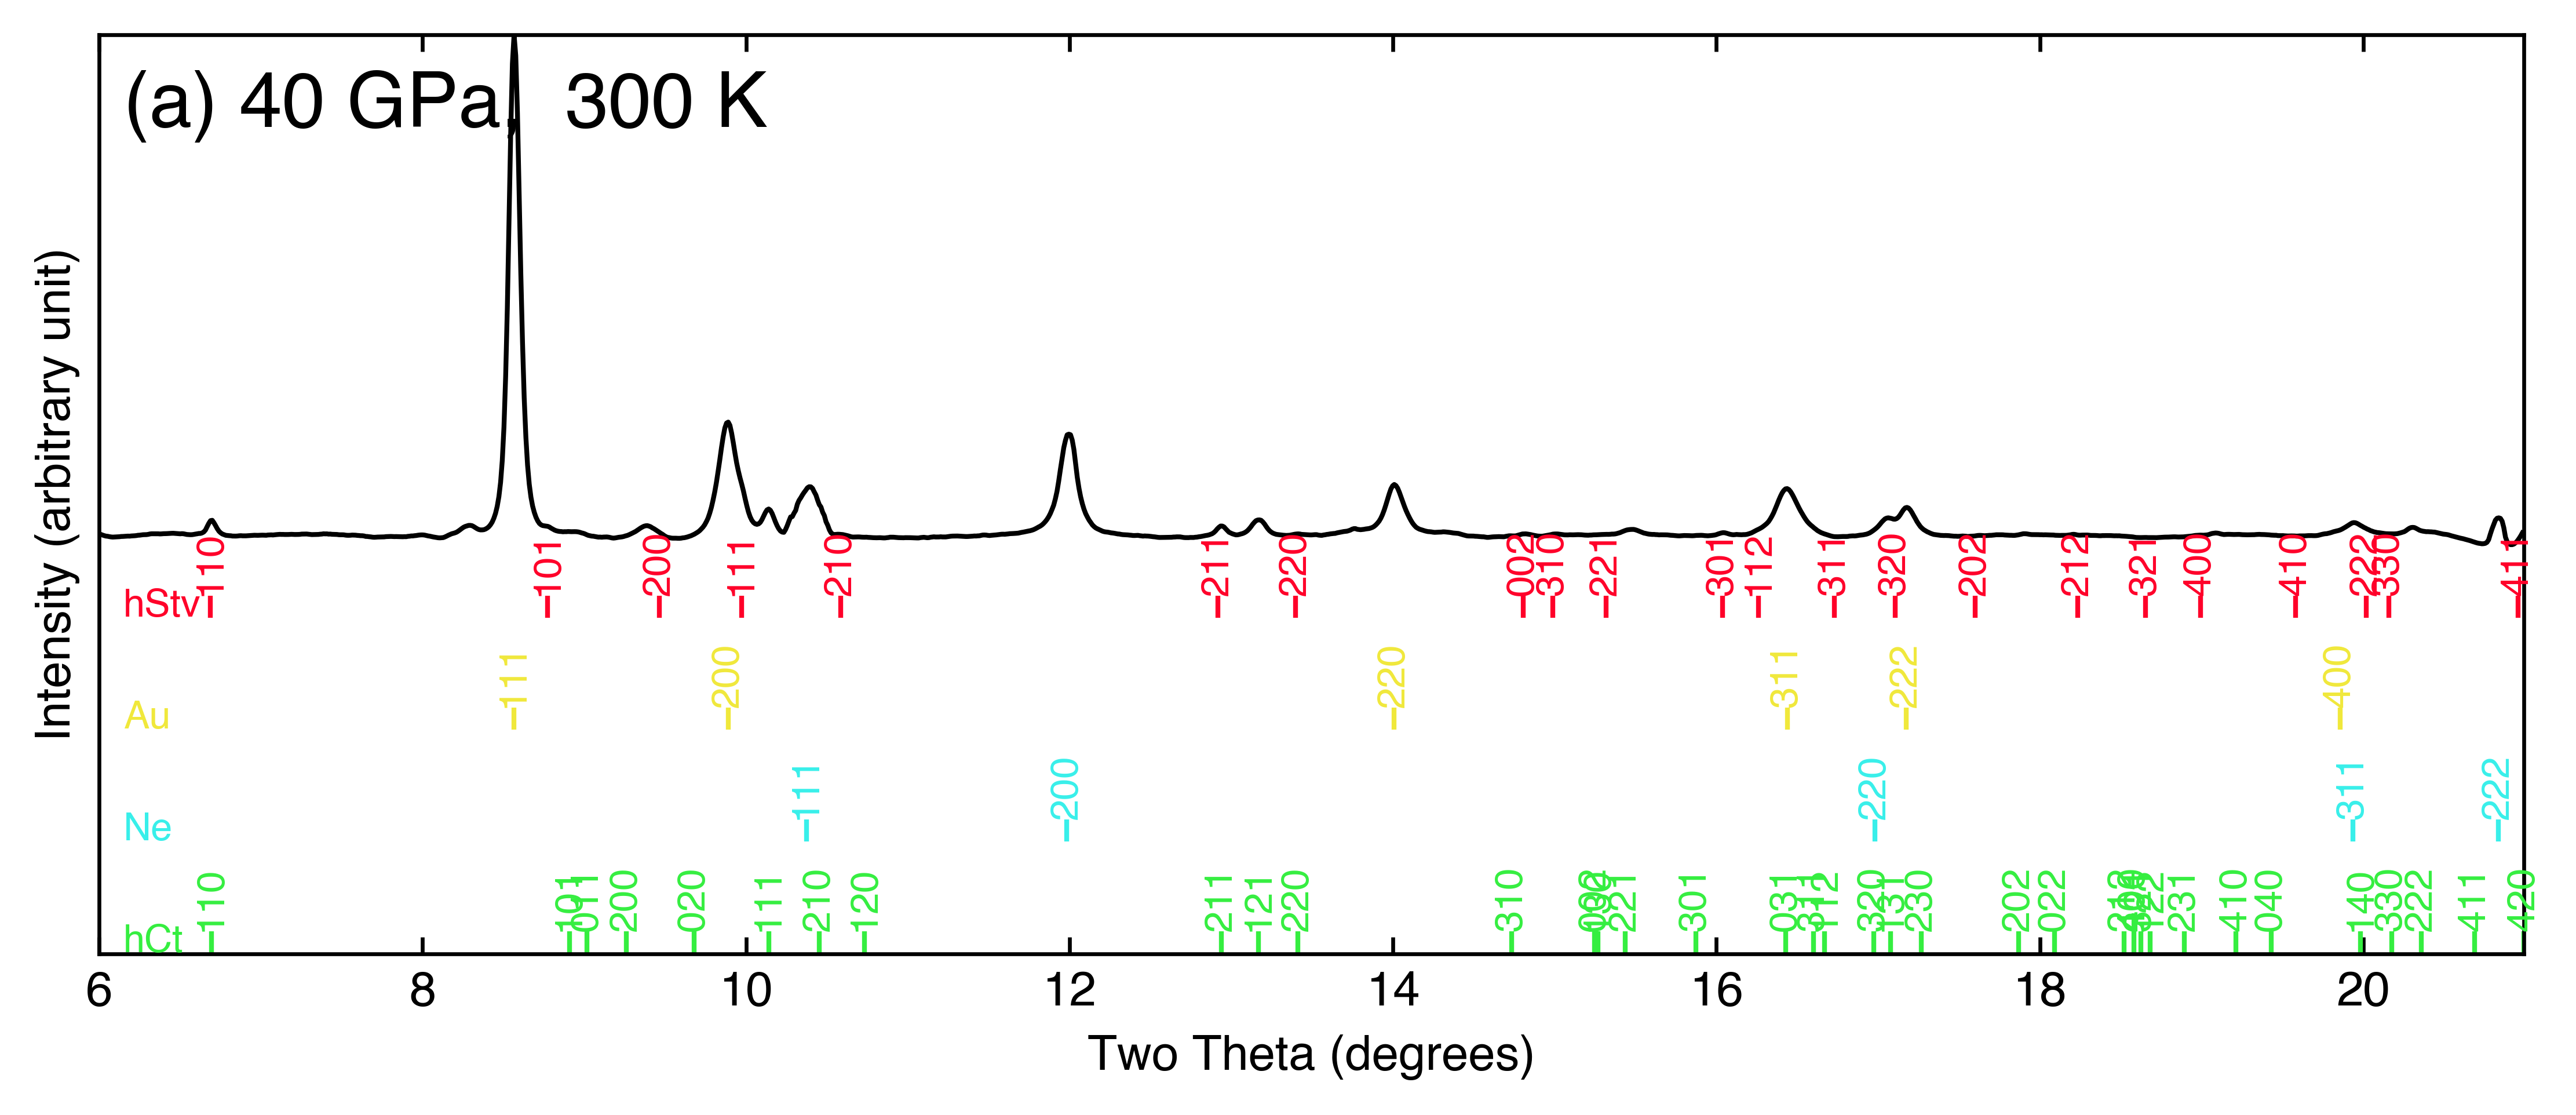

In [33]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

f, ax = plt.subplots(figsize=(9,3.5), dpi=300)
plot_diffpattern(ax, model)
print(ax.axis())
plot_jcpds(ax, model, bar_position=0.1, bar_height=5, 
           show_index=True, 
           phase_names = ['hStv', 'Au', 'Ne', 'hCt'], bar_vsep=5.)
print(ax.axis())
pressure = model.get_saved_pressure()
temperature = model.get_saved_temperature()
ax.text(0.01,0.9, "(a) {0:.0f} GPa, {1: .0f} K".format(pressure, temperature), 
        transform = ax.transAxes, fontsize=16)
plt.savefig('test.pdf', bbox_inches='tight')